## Image threshold

Color selection is very important. In this notebook, I explore different color spaces and create a GUI that allows me to adjust the color range and see how these values affect the threshold image.

Here are some website that I found really helpful:
1. http://colorizer.org/
2. https://en.wikipedia.org/wiki/Color_space
3. http://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html

### 1. Explore Color Spaces

We are all familiar with RGB color space. However, there are many color spaces that are more powerful in detecting yellow and white color. Here are some summary:

1. HLS: Hue, Lightness, Saturation
2. HSV: Hue, Saturation, Value (similar to lightness)
3. CIE LUV: L - luminance, U - blue luminance, V - red luminance
4. CIE LAB: L - luminance, a: green–red, b: blue–yellow

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
def hls_thresh(img, s_thresh, r_thresh):
    # Yellow Line filter
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # White Line filter
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    mask = np.zeros_like(s_channel)
    mask[(s_binary == 1) | (r_binary == 1)] = 1
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def hsv_thresh(img, l_yellow, h_yellow, l_white, h_white):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, l_yellow, h_yellow)
    white = cv2.inRange(hsv, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def luv_thresh(img, l_yellow, h_yellow, l_white, h_white):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    yellow = cv2.inRange(luv, l_yellow, h_yellow)
    white = cv2.inRange(luv, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def lab_thresh(img, l_yellow, h_yellow, l_white, h_white):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    yellow = cv2.inRange(lab, l_yellow, h_yellow)
    white = cv2.inRange(lab, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

### 2. Adjust Parameter

I use lower and upper value to select yellow and white color and I also built a GUI that allows me play with the value and see how it affects the threshold image.

In [9]:
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import interact

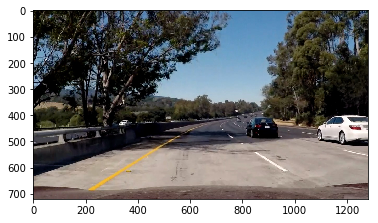

((0, 0, 0), (255, 255, 255), (127, 127, 127), (127, 127, 127))

In [16]:
from ipywidgets import interact

def mask(y_l1, y_l2, y_l3, y_u1, y_u2, y_u3, w_l1, w_l2, w_l3, w_u1, w_u2, w_u3):
    image = mpimg.imread('./test_images/test5.jpg')
    lower_yellow = np.array([y_l1, y_l2, y_l3])
    upper_yellow = np.array([y_u1, y_u2, y_u3])
    lower_white = np.array([w_l1, w_l2, w_l3])
    upper_white = np.array([w_u1, w_u2, w_u3])
    mask, res = hsv_thresh(image, lower_yellow, upper_yellow, lower_white, upper_white)
    plt.imshow(res)
    plt.show()
    return (y_l1, y_l2, y_l3), (y_u1, y_u2, y_u3), (w_l1, w_l2, w_l3), (w_u1, w_u2, w_u3)

v = (0,255,1)

interact(mask, y_l1=v, y_l2=v, y_l3=v, y_u1=v, y_u2=v, y_u3=v, w_l1=v, w_l2=v, w_l3=v, w_u1=v, w_u2=v, w_u3=v)

## 3. Test on video

In [17]:
def process_image(img):
    result = np.zeros_like(img)
    w = np.int(img.shape[1]/2)
    h = np.int(img.shape[0]/2)
    
    mask, hls = hls_thresh(img, s_thresh=(170, 255), r_thresh=(220, 255))
    
    lower_yellow = np.array([10, 100 ,90])
    upper_yellow = np.array([22, 220, 255])
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 25, 255])
    mask, hsv = hsv_thresh(img, lower_yellow, upper_yellow, lower_white, upper_white)
    
    lower_yellow = np.array([0, 0 , 25])
    upper_yellow = np.array([255, 95, 110])
    lower_white = np.array([200, 0, 0])
    upper_white = np.array([255, 255, 255])
    mask, luv = luv_thresh(img, lower_yellow, upper_yellow, lower_white, upper_white)
    
    lower_yellow = np.array([0, 0 , 80])
    upper_yellow = np.array([255, 255, 110])
    lower_white = np.array([196, 0, 0])
    upper_white = np.array([255, 255, 255])
    mask, lab = lab_thresh(img, lower_yellow, upper_yellow, lower_white, upper_white)

    # Add image
    result[0:h, 0:w] = cv2.resize(img, (w, h))
    result[0:h, w:] = cv2.resize(hls, (w, h))
    result[h:, 0:w] = cv2.resize(hsv, (w, h))
    result[h:, w:] = cv2.resize(lab, (w, h))
    
    # Put channel name
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result, "original", (30, 60), font, 1, (255, 255, 255), 2)
    cv2.putText(result, "hls", (w+30, 60), font, 1, (255, 255, 255), 2)
    cv2.putText(result, "hsv", (30, h+60), font, 1, (255, 255, 255), 2)
    #cv2.putText(result, "luv", (w+30, h+60), font, 1, (255, 255, 255), 2)
    cv2.putText(result, "lab", (w+30, h+60), font, 1, (255, 255, 255), 2)
    
    return result

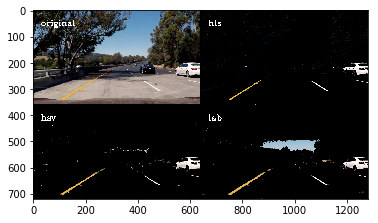

In [18]:
img = mpimg.imread('./test_images/test5.jpg')
result = process_image(img)
plt.imshow(result)
plt.show()

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
white_output = 'project_thresh.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_thresh.mp4
[MoviePy] Writing video project_thresh.mp4


100%|█████████▉| 1260/1261 [00:58<00:00, 22.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_thresh.mp4 

CPU times: user 2min 2s, sys: 21.3 s, total: 2min 23s
Wall time: 58.7 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
yellow_output = 'challenge_thresh.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video challenge_thresh.mp4
[MoviePy] Writing video challenge_thresh.mp4


100%|██████████| 485/485 [00:21<00:00, 23.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_thresh.mp4 

CPU times: user 46.2 s, sys: 7.76 s, total: 53.9 s
Wall time: 22 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))